# LU vs QR decomposition 

We will explore the use of PLU factorization, Modified GS and Classical GS for solving the linear system
$$ A\mathbf{x} = \mathbf{b}$$

where $A$ is  the  $N\times N$ matrix with the following structure

$$
A = \begin{pmatrix}
1 & 0 & 0 & 0 &\ldots & 0 & 1\\
-1 & 1 & 0 & 0 & \ldots & 0 & 1\\
-1 & -1 & 1 & 0 & \ldots & 0 &1\\
\vdots\\
-1 & -1 & -1 & \ldots & -1 & 1 & 1\\ 
-1 & -1 & -1 & \ldots & -1 & -1 & 1
\end{pmatrix}
$$

and the vector $\mathbf{b}$ is such that the solution $\mathbf{x}$ is an $N$-dimensional vector of ones.

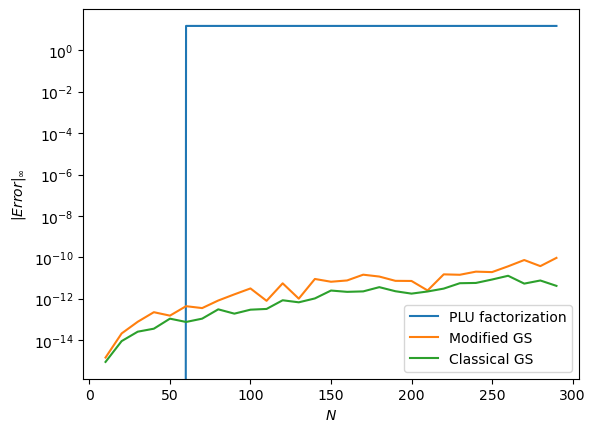

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Forward substitution
def fwd_subs(A,b):
    x = np.zeros(b.shape)
    x[0] = b[0]/A[0,0]
    
    for i in range(1,len(b)):
        x[i] = (b[i] - A[i,0:i] @ x[0:i])/A[i,i]        
    return x

# Backward substitution        
def bwd_subs(A,b):
    x = np.zeros(b.shape)
    x[-1] = b[-1]/A[-1,-1]

    for i in range(len(b)-2,-1,-1):
        x[i] = (b[i] - A[i,i+1:]@x[i+1:])/A[i,i]

    return x

# PLU decomposition    
def plu(A):
    U = np.array(A)
    N = len(A)
    L = np.eye(N)
    P = np.arange(N)
    for k in range(N-1):
        i = k + abs(U[k:,k]).argmax()
      
        if i!=k:
            L[[i,k],:k] = L[[k,i],:k]
            U[[i,k],k:] = U[[k,i],k:]
            P[[i,k]] = P[[k,i]]
        for j in range(k+1,N):
            L[j,k] = U[j,k]/U[k,k]
            U[j,k:] = U[j,k:] - L[j,k]*U[k,k:]
    return P,L,U

# Classical Gram-Schmidt
def cgs(A):
    n = len(A)
    Q = np.zeros([n,n])
    R = np.zeros([n,n])
    for j in range(n):
        Q[:,j] = A[:,j]
        R[:j,j]= np.dot(A[:,j],Q[:,:j])
        Q[:,j]-= np.dot(Q[:,:j],R[:j,j])
        R[j,j] = np.linalg.norm(Q[:,j])
        Q[:,j]/= R[j,j]  
    return Q, R


# Modified Gram-Schmidt
def mgs(Ao):
    n = len(Ao)
    A = np.array(Ao)
    R = np.zeros([n,n])
    Q = np.zeros([n,n])
    
    for i in range(n):
        R[i,i] = np.linalg.norm(A[:,i])
        Q[:,i] = A[:,i]/R[i,i]
        R[i,i+1:] = np.dot(Q[:,i],A[:,i+1:])
        A[:,i+1:]-= np.outer(Q[:,i],R[i,i+1:])
    return Q,R

# Function for generating the matrix
def formsystem(n):
    A = np.eye(n)
    A[np.tril_indices(n,-1)] = -1
    A[:,-1] = 1
    b = A @ np.ones(n)
    return A,b

# Range of values of N
N = np.arange(10,300,step=10)

Emgs = np.zeros(len(N))
Ecgs = np.zeros(len(N))
Eplu = np.zeros(len(N))

for i in range(len(N)):
    # Form the system
    A,b = formsystem(N[i])
    
    # Modified GS
    Q,R = mgs(A)
    Emgs[i] = np.linalg.norm(bwd_subs(R,Q.T@b)-1,np.inf)
    
    # Classical GS 
    Q,R = cgs(A)
    Ecgs[i] = np.linalg.norm(bwd_subs(R,Q.T@b)-1,np.inf)
    
    # PLU factorization
    P,L,U = plu(A)
    Eplu[i] = np.linalg.norm(bwd_subs(U,fwd_subs(L,b[P]))-1,np.inf)
    
# Plots #    
plt.semilogy(N,Eplu,label='PLU factorization')
plt.semilogy(N,Emgs,label='Modified GS')
plt.semilogy(N,Ecgs,label='Classical GS') 
plt.xlabel('$N$')
plt.ylabel('$\|Error\|_\infty$')
plt.legend()